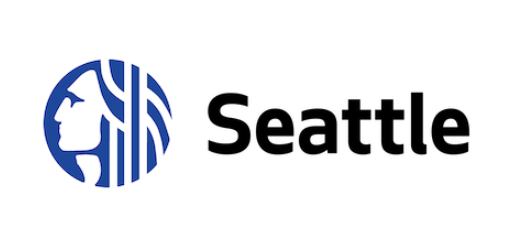

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_column', 80)

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# Contexte
Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.
Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici les données et leur source. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.



# Objectifs
Vous cherchez également à évaluer l’intérêt de l’**ENERGY STAR Score** pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

In [3]:
df = pd.read_csv('Building_Benchmarking.csv') 

In [4]:
df_log = pd.read_csv('Building_Log_Benchmarking.csv') 

Head() pour afficher les 5 premières lignes du dataframe `df`.

In [5]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,pourcentage_LargestPropertyUseTypeGFA,pourcentage_SecondLargestPropertyUseTypeGFA,pourcentage_ThirdLargestPropertyUseTypeGFA
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,47.612190,-122.337997,1927,1.0,12.0,88434,0.0,88434.0,Hotel,Hotel,NaN,NaN,65.0,78.9,173.5,6981428.0,2023032.0,3686160.0,1272388.0,249.43,100.00,0.00,0.00
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,47.613106,-122.333358,1996,1.0,11.0,103566,15064.0,88502.0,"Hotel, Parking, Restaurant",Hotel,Parking,Restaurant,51.0,94.4,191.3,8354235.0,0.0,3905411.0,4448985.0,263.51,80.99,14.55,4.46
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,47.613349,-122.337699,1969,1.0,41.0,961990,0.0,961990.0,"Hotel, Parking, Swimming Pool",Hotel,Parking,Swimming Pool,18.0,96.6,242.7,73130656.0,19660404.0,49762435.0,3709900.0,2061.48,78.72,10.40,0.00
3,5,2015,NonResidential,Hotel,HOTEL MAX,47.614216,-122.336609,1926,1.0,10.0,61320,0.0,61320.0,Hotel,Hotel,NaN,NaN,1.0,460.4,636.3,28229320.0,23458518.0,2769023.0,2001894.0,1936.34,100.00,0.00,0.00
4,9,2015,Nonresidential COS,Other,WEST PRECINCT (SEATTLE POLICE),47.616439,-122.336764,1999,1.0,2.0,97288,37198.0,60090.0,Police Station,Police Station,NaN,NaN,NaN,135.7,313.5,12051984.0,0.0,7271004.0,4781283.0,304.62,91.31,0.00,0.00


la taille du dataframe avec shape

In [6]:
df.shape

(2674, 28)

min, max, moyenne, écart type, etc) pour toutes les variables quantitatives avec describes

In [7]:
df.describe()

,OSEBuildingID,DataYear,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,pourcentage_LargestPropertyUseTypeGFA,pourcentage_SecondLargestPropertyUseTypeGFA,pourcentage_ThirdLargestPropertyUseTypeGFA
count,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2.674000e+03,2674.000000,2.674000e+03,1786.000000,2674.000000,2674.000000,2.674000e+03,2.674000e+03,2.674000e+03,2.674000e+03,2674.000000,2674.000000,2674.000000,2674.000000
mean,15453.525804,2015.512341,47.614603,-122.333696,1960.838818,1.114435,4.254675,1.184212e+05,14939.116679,1.034821e+05,64.709966,71.807530,178.210135,7.785679e+06,4.035296e+05,5.683280e+06,1.658018e+06,158.824570,82.248280,13.386945,2.135636
std,13154.516387,0.499941,0.046718,0.024022,32.955544,2.375913,6.492263,2.682347e+05,46765.031227,2.497738e+05,28.472265,74.093515,188.132233,2.454841e+07,4.330989e+06,1.816080e+07,5.853002e+06,549.857837,20.126535,21.167726,6.351193
min,1.000000,2015.000000,47.499170,-122.411820,1900.000000,1.000000,0.000000,1.128500e+04,0.000000,1.092500e+04,1.000000,0.200000,0.000000,1.144100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.080000,18.350000,0.000000,0.000000
25%,572.000000,2015.000000,47.585030,-122.343201,1929.000000,1.000000,1.000000,2.901975e+04,0.000000,2.812600e+04,48.000000,33.100000,77.400000,1.180530e+06,0.000000e+00,7.005642e+05,0.000000e+00,19.202500,66.235000,0.000000,0.000000
50%,20986.000000,2016.000000,47.611655,-122.333354,1965.000000,1.000000,2.000000,4.881950e+04,0.000000,4.664500e+04,72.000000,51.750000,132.600002,2.456574e+06,0.000000e+00,1.596202e+06,4.220580e+05,47.150000,90.860000,1.950000,0.000000
75%,24374.000000,2016.000000,47.645885,-122.322899,1988.000000,1.000000,4.000000,1.068600e+05,0.000000,9.530650e+04,88.000000,81.400001,205.200001,6.785792e+06,0.000000e+00,4.855296e+06,1.329851e+06,133.670000,100.000000,24.932500,0.000000
max,50226.000000,2016.000000,47.733870,-122.258640,2015.000000,111.000000,76.000000,9.320156e+06,512608.000000,9.320156e+06,100.000000,834.400024,2620.000000,8.739237e+08,1.349435e+08,6.570744e+08,1.381912e+08,12307.160000,100.000000,630.150000,150.940000


In [8]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'pourcentage_LargestPropertyUseTypeGFA',
       'pourcentage_SecondLargestPropertyUseTypeGFA',
       'pourcentage_ThirdLargestPropertyUseTypeGFA'],
      dtype='object')

In [9]:
for col in df.columns:
    print(f'{col :-<70} {df[col].nunique()}')

OSEBuildingID--------------------------------------------------------- 1409
DataYear-------------------------------------------------------------- 2
BuildingType---------------------------------------------------------- 4
PrimaryPropertyType--------------------------------------------------- 25
PropertyName---------------------------------------------------------- 2578
Latitude-------------------------------------------------------------- 2510
Longitude------------------------------------------------------------- 2430
YearBuilt------------------------------------------------------------- 113
NumberofBuildings----------------------------------------------------- 14
NumberofFloors-------------------------------------------------------- 43
PropertyGFATotal------------------------------------------------------ 1385
PropertyGFAParking---------------------------------------------------- 319
PropertyGFABuilding(s)------------------------------------------------ 1398
ListOfAllPropertyUseTypes-

In [10]:
#info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2674 entries, 0 to 2673
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   OSEBuildingID                                2674 non-null   int64  
 1   DataYear                                     2674 non-null   int64  
 2   BuildingType                                 2674 non-null   object 
 3   PrimaryPropertyType                          2674 non-null   object 
 4   PropertyName                                 2674 non-null   object 
 5   Latitude                                     2674 non-null   float64
 6   Longitude                                    2674 non-null   float64
 7   YearBuilt                                    2674 non-null   int64  
 8   NumberofBuildings                            2674 non-null   float64
 9   NumberofFloors                               2674 non-null   float64
 10  

# Feature Engineering

## Build Age

In [11]:
df['Build_Age'] = df['DataYear'] - df['YearBuilt']

In [12]:
df['Build_Age'].max()

116

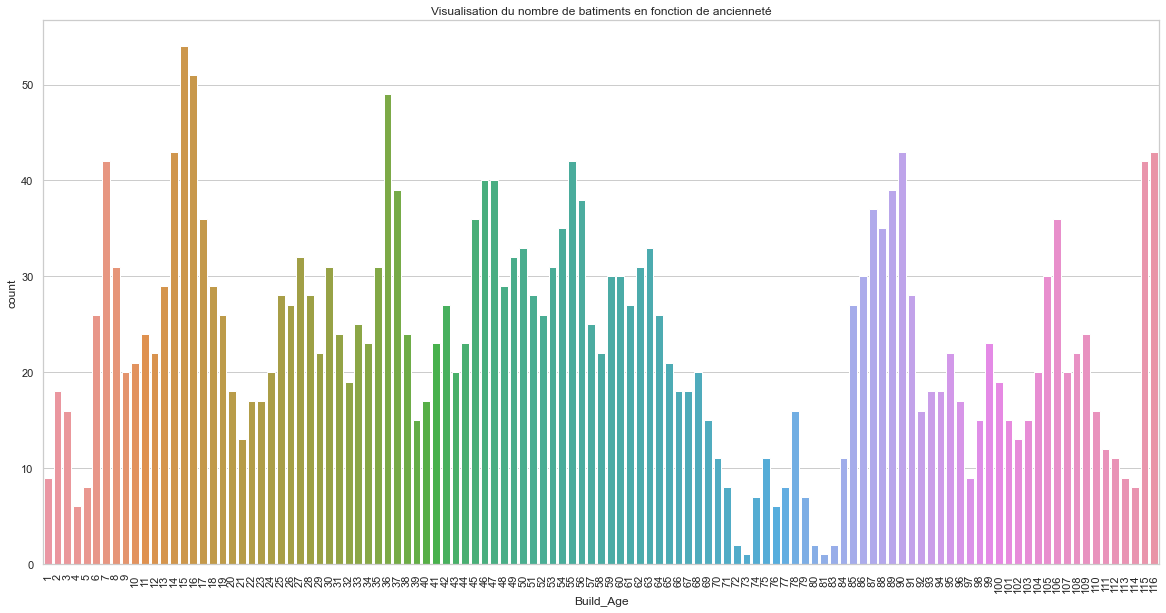

In [13]:
plt.figure(figsize=(20,10))
sns.set(font_scale=1)
sns.set_style('whitegrid')
sns.countplot(x='Build_Age', data=df).set(title='Visualisation du nombre de batiments en fonction de ancienneté')
plt.tick_params(axis='x', rotation=90)
plt.show()

In [14]:
df.drop(['OSEBuildingID', 'DataYear','YearBuilt'], axis=1, inplace=True)

## Surface Nb de Building

In [15]:
df = df.assign(surface_nb_building=lambda x: round( x['PropertyGFATotal'] / x['NumberofBuildings'], 2))

In [16]:
df.drop(['NumberofBuildings'], axis=1, inplace=True)

## Nombre d'activités

In [17]:
# Splittez la colonne en utilisant la méthode str.split()
df['ListOfAllPropertyUseTypes_split'] = df['ListOfAllPropertyUseTypes'].str.split(',')

In [18]:
# Compter le nombre d'éléments dans chaque ligne en utilisant apply()
df['nombre_activités'] = df['ListOfAllPropertyUseTypes_split'].apply(lambda x: len(x))

In [19]:
df.drop(['ListOfAllPropertyUseTypes_split'], axis=1, inplace=True)

## Energy
Nous calculons le poucentage de chaque energy ('SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu) en fonction de l'énergy total use

In [20]:
df = df.assign(pourcentage_Electricity=lambda x: round( x['Electricity(kBtu)'] / x['SiteEnergyUse(kBtu)']*100, 2))

In [21]:
df = df.assign(pourcentage_NaturalGas=lambda x: round( x['NaturalGas(kBtu)'] / x['SiteEnergyUse(kBtu)']*100, 2))

In [22]:
df = df.assign(pourcentage_SteamUse=lambda x: round( x['SteamUse(kBtu)'] / x['SiteEnergyUse(kBtu)']*100, 2))

In [23]:
df[[ 'pourcentage_Electricity', 'pourcentage_NaturalGas', 'pourcentage_SteamUse']]

,pourcentage_Electricity,pourcentage_NaturalGas,pourcentage_SteamUse
0,52.80,18.23,28.98
1,46.75,53.25,0.00
2,68.05,5.07,26.88
3,9.81,7.09,83.10
4,60.33,39.67,0.00
...,...,...,...
2669,61.70,38.30,0.00
2670,41.73,58.27,0.00
2671,31.08,68.92,0.00
2672,48.49,51.51,0.00


In [24]:
df.drop(['Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)'], axis=1, inplace=True)

## Localisation batiment - Geopandas

In [25]:
import geopandas as gpd
from shapely.geometry import Point

In [26]:
# Create a geometry column by constructing Point objects from the lon and lat columns
df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

In [27]:
# Create a GeoDataFrame from the DataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [28]:
gdf.crs

In [29]:
gdf = gdf[gdf.is_valid == True]

<AxesSubplot:>

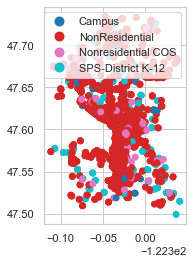

In [30]:
gdf['geometry'].centroid
gdf.plot(column = "BuildingType",legend=True)

Suite à notre feature engineering, nous vous rajouter ces nouvelles features à notre dataset df_log

In [31]:
df_feature_engineering = df[['Build_Age',
         'surface_nb_building', 'nombre_activités', 'pourcentage_Electricity',
        'pourcentage_NaturalGas', 'pourcentage_SteamUse']]

In [32]:
to_log = ['Build_Age',
          'surface_nb_building', 'nombre_activités', 'pourcentage_Electricity',
          'pourcentage_NaturalGas', 'pourcentage_SteamUse']

In [33]:
# apply log(x+1) element-wise to a subset of columns
df_log_2 = df_feature_engineering [to_log].applymap(lambda x: np.log(x+1))

# rename columns
df_log_2.columns = 'log_' + df_log_2.columns

In [34]:
# concat les deux variables à prédire et PrimaryPropertyType
df_log_3 = pd.concat([df_log, df_log_2],  axis=1)

In [35]:
df_log_3

,log_YearBuilt,log_NumberofBuildings,log_NumberofFloors,log_PropertyGFATotal,log_PropertyGFAParking,log_PropertyGFABuilding(s),log_pourcentage_LargestPropertyUseTypeGFA,log_pourcentage_SecondLargestPropertyUseTypeGFA,log_pourcentage_ThirdLargestPropertyUseTypeGFA,log_SiteEUI(kBtu/sf),log_SourceEUI(kBtu/sf),log_SiteEnergyUse(kBtu),log_SteamUse(kBtu),log_Electricity(kBtu),log_NaturalGas(kBtu),log_TotalGHGEmissions,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,log_Build_Age,log_surface_nb_building,log_nombre_activités,log_pourcentage_Electricity,log_pourcentage_NaturalGas,log_pourcentage_SteamUse
0,7.564238,0.693147,2.564949,11.390023,0.000000,11.390023,4.615121,0.000000,0.000000,4.380776,5.161925,15.758764,14.520108,15.120096,14.056407,5.523179,Hotel,NaN,NaN,4.488636,11.390023,0.693147,3.985273,2.956472,3.400530
1,7.599401,0.693147,2.484907,11.547974,9.620129,11.390792,4.406597,2.744061,1.697449,4.558079,5.259057,15.938279,0.000000,15.177874,15.308187,5.577879,Hotel,Parking,Restaurant,2.995732,11.547974,1.386294,3.865979,3.993603,0.000000
2,7.585789,0.693147,3.737670,13.776760,0.000000,13.776760,4.378520,2.433613,0.000000,4.580877,5.495938,18.107758,16.794117,17.722771,15.126516,7.631664,Hotel,Parking,Swimming Pool,3.850148,13.776760,1.386294,4.234831,1.803359,3.327910
3,7.563720,0.693147,2.397895,11.023878,0.000000,11.023878,4.615121,0.000000,0.000000,6.134265,6.457241,17.155872,16.970744,14.834005,14.509605,7.569071,Hotel,NaN,NaN,4.499810,11.023878,0.693147,2.380472,2.090629,4.432007
4,7.600902,0.693147,1.098612,11.485441,10.524037,11.003615,4.525152,0.000000,0.000000,4.917789,5.750984,16.304740,0.000000,15.799405,15.380220,5.722343,Police Station,NaN,NaN,2.833213,11.485441,0.693147,4.116269,3.705491,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,7.596392,0.693147,0.693147,9.416948,0.000000,9.416948,4.615121,0.000000,0.000000,4.249923,5.091908,13.652694,0.000000,13.169766,12.693044,3.088311,Small- and Mid-Sized Office,NaN,NaN,3.295837,9.416948,0.693147,4.138361,3.671225,0.000000
2670,7.603399,0.693147,0.693147,9.680406,0.000000,9.680406,4.615121,0.000000,0.000000,4.100989,4.746670,13.764509,0.000000,12.890550,13.224434,3.501646,Other - Recreation,NaN,NaN,2.564949,9.680406,0.693147,3.754901,4.082103,0.000000
2671,7.588324,0.693147,0.693147,9.484785,0.000000,9.484785,4.071247,3.769768,0.000000,6.084955,6.614457,15.567472,0.000000,14.398932,15.195218,5.414054,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,3.761200,9.484785,1.386294,3.468233,4.247352,0.000000
2672,7.595890,0.693147,0.693147,9.554072,0.000000,9.554072,3.867235,3.852273,1.488400,3.951244,4.666265,13.486273,0.000000,12.762458,12.822884,3.140265,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,3.332205,9.554072,1.791759,3.901771,3.961004,0.000000


Nous supprimons maintenant les features qui nous semblent moins pertinentes pour la suite de notre analyse

In [36]:
df_log_3.columns

Index(['log_YearBuilt', 'log_NumberofBuildings', 'log_NumberofFloors',
       'log_PropertyGFATotal', 'log_PropertyGFAParking',
       'log_PropertyGFABuilding(s)',
       'log_pourcentage_LargestPropertyUseTypeGFA',
       'log_pourcentage_SecondLargestPropertyUseTypeGFA',
       'log_pourcentage_ThirdLargestPropertyUseTypeGFA',
       'log_SiteEUI(kBtu/sf)', 'log_SourceEUI(kBtu/sf)',
       'log_SiteEnergyUse(kBtu)', 'log_SteamUse(kBtu)',
       'log_Electricity(kBtu)', 'log_NaturalGas(kBtu)',
       'log_TotalGHGEmissions', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'log_Build_Age', 'log_surface_nb_building', 'log_nombre_activités',
       'log_pourcentage_Electricity', 'log_pourcentage_NaturalGas',
       'log_pourcentage_SteamUse'],
      dtype='object')

In [37]:
df_log_3.drop(['log_YearBuilt','log_PropertyGFAParking','log_SiteEnergyUse(kBtu)', 'log_SteamUse(kBtu)',
         'log_Electricity(kBtu)', 'log_NaturalGas(kBtu)','log_TotalGHGEmissions'], axis=1, inplace=True)

# Encodage

In [38]:
cat_cols = ['LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
num_cols = ['log_YearBuilt', 'log_NumberofBuildings', 'log_NumberofFloors',
       'log_PropertyGFATotal', 'log_PropertyGFAParking',
       'log_PropertyGFABuilding(s)', 'log_LargestPropertyUseTypeGFA',
       'log_SiteEUI(kBtu/sf)', 'log_SourceEUI(kBtu/sf)',
       'log_SiteEnergyUse(kBtu)', 'log_SteamUse(kBtu)',
       'log_Electricity(kBtu)', 'log_NaturalGas(kBtu)',
       'log_TotalGHGEmissions']

In [39]:
df_log_3

,log_NumberofBuildings,log_NumberofFloors,log_PropertyGFATotal,log_PropertyGFABuilding(s),log_pourcentage_LargestPropertyUseTypeGFA,log_pourcentage_SecondLargestPropertyUseTypeGFA,log_pourcentage_ThirdLargestPropertyUseTypeGFA,log_SiteEUI(kBtu/sf),log_SourceEUI(kBtu/sf),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,log_Build_Age,log_surface_nb_building,log_nombre_activités,log_pourcentage_Electricity,log_pourcentage_NaturalGas,log_pourcentage_SteamUse
0,0.693147,2.564949,11.390023,11.390023,4.615121,0.000000,0.000000,4.380776,5.161925,Hotel,NaN,NaN,4.488636,11.390023,0.693147,3.985273,2.956472,3.400530
1,0.693147,2.484907,11.547974,11.390792,4.406597,2.744061,1.697449,4.558079,5.259057,Hotel,Parking,Restaurant,2.995732,11.547974,1.386294,3.865979,3.993603,0.000000
2,0.693147,3.737670,13.776760,13.776760,4.378520,2.433613,0.000000,4.580877,5.495938,Hotel,Parking,Swimming Pool,3.850148,13.776760,1.386294,4.234831,1.803359,3.327910
3,0.693147,2.397895,11.023878,11.023878,4.615121,0.000000,0.000000,6.134265,6.457241,Hotel,NaN,NaN,4.499810,11.023878,0.693147,2.380472,2.090629,4.432007
4,0.693147,1.098612,11.485441,11.003615,4.525152,0.000000,0.000000,4.917789,5.750984,Police Station,NaN,NaN,2.833213,11.485441,0.693147,4.116269,3.705491,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,0.693147,0.693147,9.416948,9.416948,4.615121,0.000000,0.000000,4.249923,5.091908,Small- and Mid-Sized Office,NaN,NaN,3.295837,9.416948,0.693147,4.138361,3.671225,0.000000
2670,0.693147,0.693147,9.680406,9.680406,4.615121,0.000000,0.000000,4.100989,4.746670,Other - Recreation,NaN,NaN,2.564949,9.680406,0.693147,3.754901,4.082103,0.000000
2671,0.693147,0.693147,9.484785,9.484785,4.071247,3.769768,0.000000,6.084955,6.614457,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,3.761200,9.484785,1.386294,3.468233,4.247352,0.000000
2672,0.693147,0.693147,9.554072,9.554072,3.867235,3.852273,1.488400,3.951244,4.666265,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,3.332205,9.554072,1.791759,3.901771,3.961004,0.000000


In [40]:
df_log_3.LargestPropertyUseType.value_counts().sort_values(ascending = False).head(30)


occurring_cat = [cat for cat in df_log_3.LargestPropertyUseType.value_counts().sort_values(ascending = False).head(40).index]


for cat in occurring_cat:
    df_log_3[cat] = np.where((df_log_3['LargestPropertyUseType'] == cat)|
                           (df_log_3['SecondLargestPropertyUseType'] == cat)|
                           (df_log_3['ThirdLargestPropertyUseType'] == cat), 1, 0) 

In [41]:
df_log_3.columns

Index(['log_NumberofBuildings', 'log_NumberofFloors', 'log_PropertyGFATotal',
       'log_PropertyGFABuilding(s)',
       'log_pourcentage_LargestPropertyUseTypeGFA',
       'log_pourcentage_SecondLargestPropertyUseTypeGFA',
       'log_pourcentage_ThirdLargestPropertyUseTypeGFA',
       'log_SiteEUI(kBtu/sf)', 'log_SourceEUI(kBtu/sf)',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'log_Build_Age',
       'log_surface_nb_building', 'log_nombre_activités',
       'log_pourcentage_Electricity', 'log_pourcentage_NaturalGas',
       'log_pourcentage_SteamUse', 'Small- and Mid-Sized Office', 'Warehouse',
       'K-12 School', 'Other', 'Retail Store', 'Hotel', 'Worship Facility',
       'Distribution Center', 'Medical Office', 'Supermarket / Grocery Store',
       'Self-Storage Facility', 'Other - Recreation', 'Parking',
       'Other - Entertainment/Public Assembly', 'University', 'Restaurant',
       'Refrigerated Warehouse', 'Social

## GFA Property encode
### Assign log_pourcentage_LargestPropertyUseTypeGFA

In [42]:
# colonne pour la surface GFA log_pourcentage_LargestPropertyUseTypeGFA
gfa_col = 'log_pourcentage_LargestPropertyUseTypeGFA'

# colonne pour le type de propriété
property_col = 'LargestPropertyUseType'

# liste des colonnes features
features_cols = ['Small- and Mid-Sized Office', 'Warehouse',
                 'K-12 School', 'Other', 'Retail Store', 'Hotel', 'Worship Facility',
                 'Distribution Center', 'Medical Office', 'Supermarket / Grocery Store',
                 'Self-Storage Facility', 'Other - Recreation', 'Parking',
                 'Other - Entertainment/Public Assembly', 'University', 'Restaurant',
                 'Refrigerated Warehouse', 'Social/Meeting Hall', 'Laboratory',
                 'Manufacturing/Industrial Plant', 'Automobile Dealership',
                 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Museum',
                 'Hospital (General Medical & Surgical)', 'Library', 'Other - Services',
                 'Bank Branch', 'Urgent Care/Clinic/Other Outpatient', 'Other - Mall',
                 'Other - Education', 'Fitness Center/Health Club/Gym',
                 'Financial Office', 'Other/Specialty Hospital', 'Strip Mall',
                 'Performing Arts', 'Data Center', 'Pre-school/Daycare',
                 'Adult Education', 'Other - Restaurant/Bar', 'Prison/Incarceration']

# Boucle pour chaque feature
for feature in features_cols:
    # Selection des lignes ou la feature de type de propriété est égale à la feature en cours de traitement
    mask = df_log_3[property_col] == feature
    # Assignation de la valeur de la colonne gfa_col à la colonne feature en cours de traitement
    df_log_3.loc[mask, feature] = df_log_3.loc[mask, gfa_col]

### Assign log_pourcentage_SecondLargestPropertyUseTypeGFA

In [43]:
# colonne pour la surface GFA log_pourcentage_SecondLargestPropertyUseTypeGFA
gfa_col = 'log_pourcentage_SecondLargestPropertyUseTypeGFA'

# colonne pour le type de propriété
property_col = 'SecondLargestPropertyUseType'

# liste des colonnes features
features_cols = ['Small- and Mid-Sized Office', 'Warehouse',
                 'K-12 School', 'Other', 'Retail Store', 'Hotel', 'Worship Facility',
                 'Distribution Center', 'Medical Office', 'Supermarket / Grocery Store',
                 'Self-Storage Facility', 'Other - Recreation', 'Parking',
                 'Other - Entertainment/Public Assembly', 'University', 'Restaurant',
                 'Refrigerated Warehouse', 'Social/Meeting Hall', 'Laboratory',
                 'Manufacturing/Industrial Plant', 'Automobile Dealership',
                 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Museum',
                 'Hospital (General Medical & Surgical)', 'Library', 'Other - Services',
                 'Bank Branch', 'Urgent Care/Clinic/Other Outpatient', 'Other - Mall',
                 'Other - Education', 'Fitness Center/Health Club/Gym',
                 'Financial Office', 'Other/Specialty Hospital', 'Strip Mall',
                 'Performing Arts', 'Data Center', 'Pre-school/Daycare',
                 'Adult Education', 'Other - Restaurant/Bar', 'Prison/Incarceration']

# Boucle pour chaque feature
for feature in features_cols:
    # Selection des lignes ou la feature de type de propriété est égale à la feature en cours de traitement
    mask = df_log_3[property_col] == feature
    # Assignation de la valeur de la colonne gfa_col à la colonne feature en cours de traitement
    df_log_3.loc[mask, feature] = df_log_3.loc[mask, gfa_col]

### Assign log_pourcentage_ThirdLargestPropertyUseTypeGFA

In [44]:
# colonne pour la surface GFA log_pourcentage_ThirdLargestPropertyUseTypeGFA
gfa_col ='log_pourcentage_ThirdLargestPropertyUseTypeGFA'

# colonne pour le type de propriété
property_col ='ThirdLargestPropertyUseType'

# liste des colonnes features
features_cols = ['Small- and Mid-Sized Office', 'Warehouse',
                 'K-12 School', 'Other', 'Retail Store', 'Hotel', 'Worship Facility',
                 'Distribution Center', 'Medical Office', 'Supermarket / Grocery Store',
                 'Self-Storage Facility', 'Other - Recreation', 'Parking',
                 'Other - Entertainment/Public Assembly', 'University', 'Restaurant',
                 'Refrigerated Warehouse', 'Social/Meeting Hall', 'Laboratory',
                 'Manufacturing/Industrial Plant', 'Automobile Dealership',
                 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Museum',
                 'Hospital (General Medical & Surgical)', 'Library', 'Other - Services',
                 'Bank Branch', 'Urgent Care/Clinic/Other Outpatient', 'Other - Mall',
                 'Other - Education', 'Fitness Center/Health Club/Gym',
                 'Financial Office', 'Other/Specialty Hospital', 'Strip Mall',
                 'Performing Arts', 'Data Center', 'Pre-school/Daycare',
                 'Adult Education', 'Other - Restaurant/Bar', 'Prison/Incarceration']

# Boucle pour chaque feature
for feature in features_cols:
    # Selection des lignes ou la feature de type de propriété est égale à la feature en cours de traitement
    mask = df_log_3[property_col] == feature
    # Assignation de la valeur de la colonne gfa_col à la colonne feature en cours de traitement
    df_log_3.loc[mask, feature] = df_log_3.loc[mask, gfa_col]

In [45]:
df_log_3

,log_NumberofBuildings,log_NumberofFloors,log_PropertyGFATotal,log_PropertyGFABuilding(s),log_pourcentage_LargestPropertyUseTypeGFA,log_pourcentage_SecondLargestPropertyUseTypeGFA,log_pourcentage_ThirdLargestPropertyUseTypeGFA,log_SiteEUI(kBtu/sf),log_SourceEUI(kBtu/sf),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,log_Build_Age,log_surface_nb_building,log_nombre_activités,log_pourcentage_Electricity,log_pourcentage_NaturalGas,log_pourcentage_SteamUse,Small- and Mid-Sized Office,Warehouse,K-12 School,Other,Retail Store,Hotel,Worship Facility,Distribution Center,Medical Office,Supermarket / Grocery Store,Self-Storage Facility,Other - Recreation,Parking,Other - Entertainment/Public Assembly,University,Restaurant,Refrigerated Warehouse,Social/Meeting Hall,Laboratory,Automobile Dealership,Manufacturing/Industrial Plant,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Museum,Hospital (General Medical & Surgical),Library,Bank Branch,Other - Services,Urgent Care/Clinic/Other Outpatient,Other - Education,Fitness Center/Health Club/Gym,Financial Office,Other - Mall,Strip Mall,Other/Specialty Hospital,Performing Arts,Data Center,Other - Restaurant/Bar,Pre-school/Daycare,Adult Education,Prison/Incarceration
0,0.693147,2.564949,11.390023,11.390023,4.615121,0.000000,0.000000,4.380776,5.161925,Hotel,NaN,NaN,4.488636,11.390023,0.693147,3.985273,2.956472,3.400530,0.000000,0.0,0.0,0.0,0.0,4.615121,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
1,0.693147,2.484907,11.547974,11.390792,4.406597,2.744061,1.697449,4.558079,5.259057,Hotel,Parking,Restaurant,2.995732,11.547974,1.386294,3.865979,3.993603,0.000000,0.000000,0.0,0.0,0.0,0.0,4.406597,0.0,0.0,0.0,0.0,0.0,0.000000,2.744061,0.0,0.0,1.697449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.693147,3.737670,13.776760,13.776760,4.378520,2.433613,0.000000,4.580877,5.495938,Hotel,Parking,Swimming Pool,3.850148,13.776760,1.386294,4.234831,1.803359,3.327910,0.000000,0.0,0.0,0.0,0.0,4.378520,0.0,0.0,0.0,0.0,0.0,0.000000,2.433613,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
3,0.693147,2.397895,11.023878,11.023878,4.615121,0.000000,0.000000,6.134265,6.457241,Hotel,NaN,NaN,4.499810,11.023878,0.693147,2.380472,2.090629,4.432007,0.000000,0.0,0.0,0.0,0.0,4.615121,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
4,0.693147,1.098612,11.485441,11.003615,4.525152,0.000000,0.000000,4.917789,5.750984,Police Station,NaN,NaN,2.833213,11.485441,0.693147,4.116269,3.705491,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,0.693147,0.693147,9.416948,9.416948,4.615121,0.000000,0.000000,4.249923,5.091908,Small- and Mid-Sized Office,NaN,NaN,3.295837,9.416948,0.693147,4.138361,3.671225,0.000000,4.615121,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2670,0.693147,0.693147,9.680406,9.680406,4.615121,0.000000,0.000000,4.100989,4.746670,Other - Recreation,NaN,NaN,2.564949,9.680406,0.693147,3.754901,4.082103,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4.615121,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2671,0.6

In [46]:
# drop catégorical feature
df_log_3.drop(['LargestPropertyUseType',
               'SecondLargestPropertyUseType', 
               'ThirdLargestPropertyUseType', 
               'log_pourcentage_LargestPropertyUseTypeGFA',
               'log_pourcentage_SecondLargestPropertyUseTypeGFA',
               'log_pourcentage_ThirdLargestPropertyUseTypeGFA'], axis=1, inplace=True)

In [47]:
df_log_3

,log_NumberofBuildings,log_NumberofFloors,log_PropertyGFATotal,log_PropertyGFABuilding(s),log_SiteEUI(kBtu/sf),log_SourceEUI(kBtu/sf),log_Build_Age,log_surface_nb_building,log_nombre_activités,log_pourcentage_Electricity,log_pourcentage_NaturalGas,log_pourcentage_SteamUse,Small- and Mid-Sized Office,Warehouse,K-12 School,Other,Retail Store,Hotel,Worship Facility,Distribution Center,Medical Office,Supermarket / Grocery Store,Self-Storage Facility,Other - Recreation,Parking,Other - Entertainment/Public Assembly,University,Restaurant,Refrigerated Warehouse,Social/Meeting Hall,Laboratory,Automobile Dealership,Manufacturing/Industrial Plant,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Museum,Hospital (General Medical & Surgical),Library,Bank Branch,Other - Services,Urgent Care/Clinic/Other Outpatient,Other - Education,Fitness Center/Health Club/Gym,Financial Office,Other - Mall,Strip Mall,Other/Specialty Hospital,Performing Arts,Data Center,Other - Restaurant/Bar,Pre-school/Daycare,Adult Education,Prison/Incarceration
0,0.693147,2.564949,11.390023,11.390023,4.380776,5.161925,4.488636,11.390023,0.693147,3.985273,2.956472,3.400530,0.000000,0.0,0.0,0.0,0.0,4.615121,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
1,0.693147,2.484907,11.547974,11.390792,4.558079,5.259057,2.995732,11.547974,1.386294,3.865979,3.993603,0.000000,0.000000,0.0,0.0,0.0,0.0,4.406597,0.0,0.0,0.0,0.0,0.0,0.000000,2.744061,0.0,0.0,1.697449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.693147,3.737670,13.776760,13.776760,4.580877,5.495938,3.850148,13.776760,1.386294,4.234831,1.803359,3.327910,0.000000,0.0,0.0,0.0,0.0,4.378520,0.0,0.0,0.0,0.0,0.0,0.000000,2.433613,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
3,0.693147,2.397895,11.023878,11.023878,6.134265,6.457241,4.499810,11.023878,0.693147,2.380472,2.090629,4.432007,0.000000,0.0,0.0,0.0,0.0,4.615121,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
4,0.693147,1.098612,11.485441,11.003615,4.917789,5.750984,2.833213,11.485441,0.693147,4.116269,3.705491,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,0.693147,0.693147,9.416948,9.416948,4.249923,5.091908,3.295837,9.416948,0.693147,4.138361,3.671225,0.000000,4.615121,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2670,0.693147,0.693147,9.680406,9.680406,4.100989,4.746670,2.564949,9.680406,0.693147,3.754901,4.082103,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4.615121,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2671,0.693147,0.693147,9.484785,9.484785,6.084955,6.614457,3.761200,9.484785,1.386294,3.468233,4.247352,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4.071247,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.769768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2672,0.693147,0.693147,9.554072,9.554072,3.951244,4.666265,3.332205,9.554072,1.791759,3.901771,3.961004,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3.867235,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.852273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.48840

# Target Feature

In [48]:
# on rajoute les valeurs à prédire et l'énergystarsscore pour pouvoir évaluer la perfomance de notre model
df_energy = df[['SiteEnergyUse(kBtu)', 'ENERGYSTARScore']]

In [49]:
df_emissions = df[['TotalGHGEmissions', 'ENERGYSTARScore']]

In [50]:
# concat les deux variables à prédire
df_energy = pd.concat([df_log_3, df_energy],  axis=1)
df_emissions = pd.concat([df_log_3, df_emissions],  axis=1)

In [51]:
df_energy.to_csv('Building_Energy_Benchmarking.csv', index=False, header=True)
df_emissions.to_csv('Building_Emissions_Benchmarking.csv', index=False, header=True)

In [52]:
df_pred_energy = pd.read_csv('Building_Energy_Benchmarking.csv') 

In [53]:
df_pred_energy.isna().sum()

log_NumberofBuildings                                0
log_NumberofFloors                                   0
log_PropertyGFATotal                                 0
log_PropertyGFABuilding(s)                           0
log_SiteEUI(kBtu/sf)                                 0
log_SourceEUI(kBtu/sf)                               0
log_Build_Age                                        0
log_surface_nb_building                              0
log_nombre_activités                                 0
log_pourcentage_Electricity                          0
log_pourcentage_NaturalGas                           0
log_pourcentage_SteamUse                             0
Small- and Mid-Sized Office                          0
Warehouse                                            0
K-12 School                                          0
Other                                                0
Retail Store                                         0
Hotel                                                0
Worship Fa

# Prediction Energy sans ENERGYSTARScore

In [54]:
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from math import sqrt

In [55]:
# Sélection des variables X et y
X=df_pred_energy.drop(['SiteEnergyUse(kBtu)','ENERGYSTARScore'],axis=1)
y= df_pred_energy['SiteEnergyUse(kBtu)']

In [56]:
# Séparation des données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## DummyRegressor

### strategy='mean'

In [57]:
# Initialisation et entraînement du modèle
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = dummy_regr.predict(X_test)

# Évaluation des performances
r2 = r2_score(y_test, y_pred)
print("R^2: ", r2)

R^2:  -0.0002725392536764293


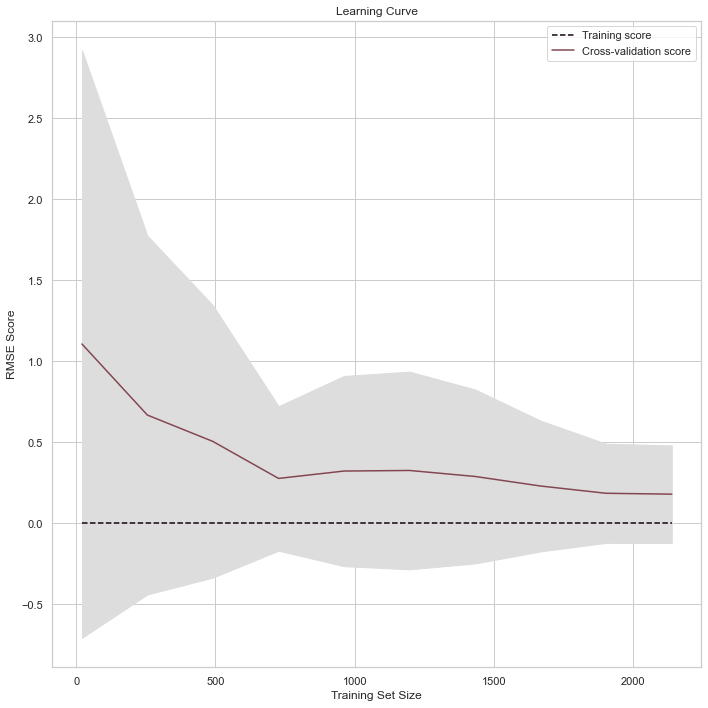

In [58]:
# Définir les tailles d'échantillon pour la courbe d'apprentissage
train_sizes = np.linspace(0.01, 1, 10)

# Calculer les scores pour chaque taille d'échantillon
train_sizes, train_scores, test_scores = learning_curve(dummy_regr, X, y, train_sizes=train_sizes, cv=5, scoring='r2')

# Calculer les moyennes et les écarts-types des scores
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)


# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

Coeff R2 = -2.7963550629728218e-05


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

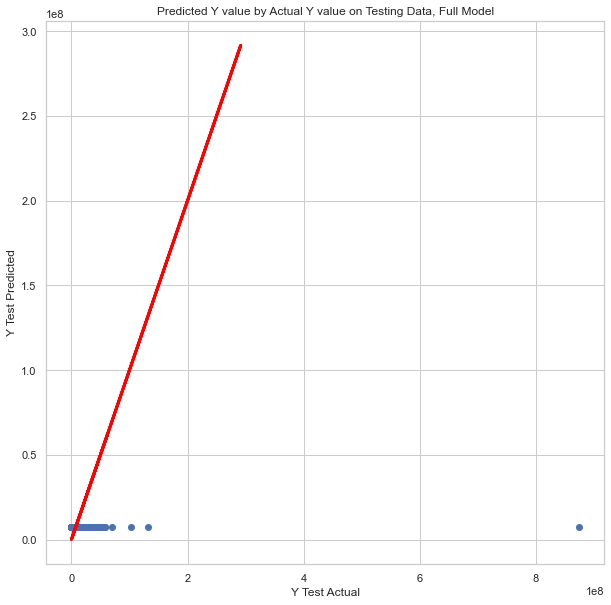

In [59]:
print('Coeff R2 =', dummy_regr.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, dummy_regr.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")


### strategy='median'

In [60]:
# Initialisation et entraînement du modèle
dummy_regr = DummyRegressor(strategy='median')
dummy_regr.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = dummy_regr.predict(X_test)

# Évaluation des performances
r2 = r2_score(y_test, y_pred)
print("R^2: ", r2)

R^2:  -0.022145687592258323


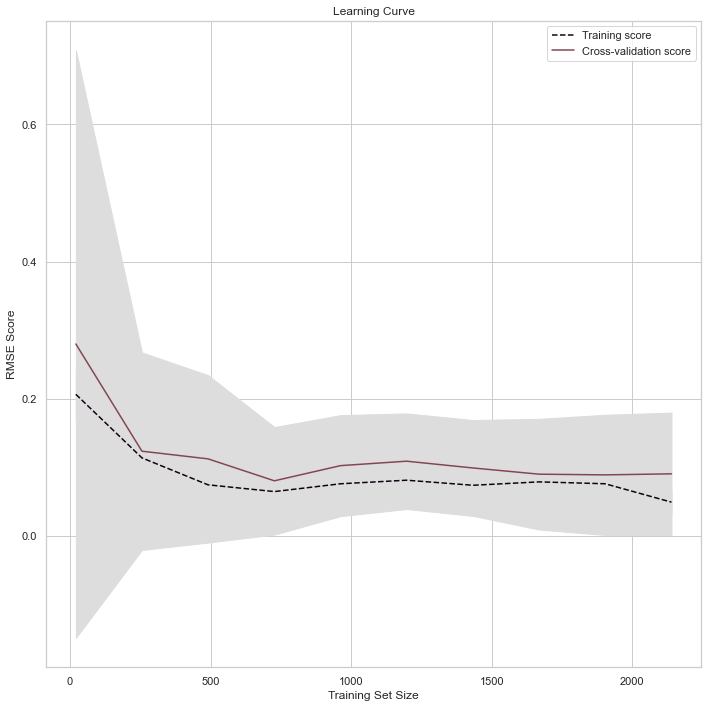

In [61]:
# Définir les tailles d'échantillon pour la courbe d'apprentissage
train_sizes = np.linspace(0.01, 1, 10)

# Calculer les scores pour chaque taille d'échantillon
train_sizes, train_scores, test_scores = learning_curve(dummy_regr, X, y, train_sizes=train_sizes, cv=5, scoring='r2')

# Calculer les moyennes et les écarts-types des scores
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

Coeff R2 = -0.04713595344032573


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

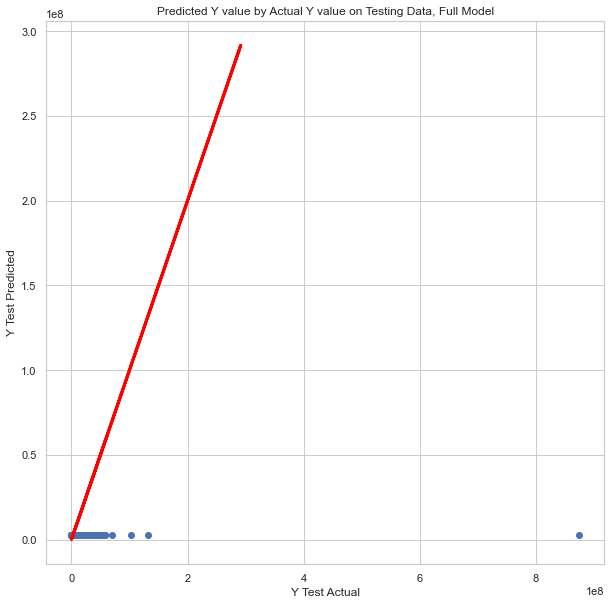

In [62]:
print('Coeff R2 =', dummy_regr.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, dummy_regr.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")


### Cross-Validation 

La cross-validation est une technique utilisée dans l'apprentissage automatique pour évaluer la performance d'un modèle. Il permet de mesurer la capacité de généralisation d'un modèle, c'est-à-dire sa capacité à prédire de manière efficace sur des données qu'il n'a pas encore vues.

Il existe plusieurs techniques de validation croisée, mais la plus courante est la validation croisée K-fold. Cela consiste à diviser les données en K parties égales, appelées "volets", et à utiliser K-1 volets pour entraîner le modèle et un seul volet pour l'évaluer. Ce processus est répété K fois, en utilisant chaque volet comme volet de test une fois. Les résultats de chaque itération sont ensuite combinés pour obtenir une estimation de la performance globale du modèle.

La cross-validation est particulièrement utile lorsque les données sont limitées, car elle permet d'utiliser toutes les données disponibles pour l'entraînement et l'évaluation du modèle, ce qui réduit les biais dans l'évaluation de la performance. C'est aussi une technique très utilisée pour sélectionner les hyperparamètres d'un modèle, c'est-à-dire les paramètres qui ne sont pas appris directement à partir des données, mais qui sont définis avant l'entraînement.

In [63]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [64]:
kfold_validation=KFold(10)

In [65]:
results=cross_val_score(dummy_regr,X,y,cv=kfold_validation)
print(results)
print(np.mean(results))

[-3.24160797e-01 -1.07725054e-01 -1.48272378e-03 -2.58837868e-03
 -6.61757386e-02 -3.45594133e-01 -1.02093802e-01 -1.48472350e-03
 -2.61390216e-04 -1.09081079e-02]
-0.09624748489285331


## Regression Linéaire

In [66]:
# Initialisation et entraînement du modèle
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = lr.predict(X_test)

# Évaluation des performances
r2 = r2_score(y_test, y_pred)
print("R^2: ", r2)

R^2:  0.1998027878894314


In [67]:
train_sizes, train_scores, test_scores = learning_curve(LinearRegression(), X, y, train_sizes=train_sizes, cv=5, scoring='r2')

In [68]:
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)

In [69]:
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

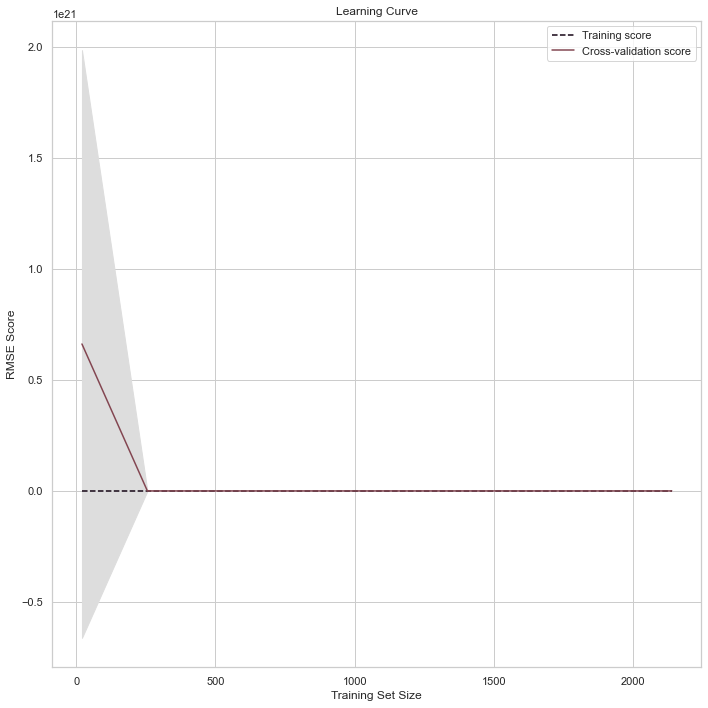

In [70]:
# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

Coeff R2 = 0.4221418523337924


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

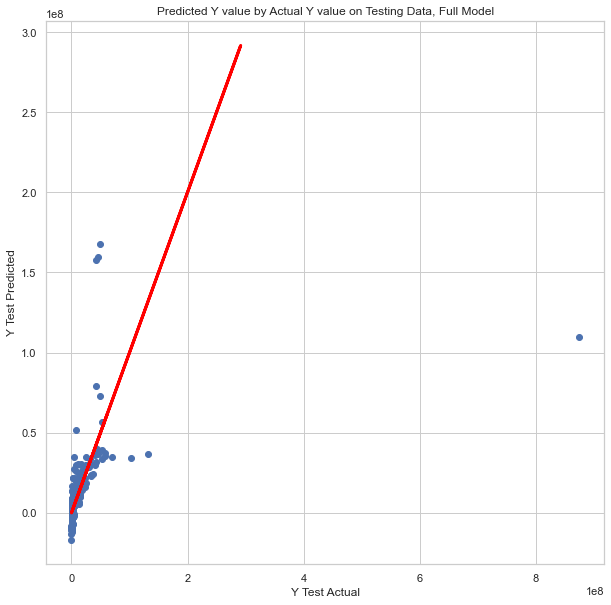

In [71]:
print('Coeff R2 =', lr.score(X,y))
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, lr.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")


In [72]:
mse = mean_squared_error(y_test, y_pred)
print(mse)

1235548096413791.5


### Cross-Validation 

In [73]:
results=cross_val_score(lr,X,y,cv=kfold_validation)
print(results)
print(np.mean(results))

[ 0.32834705  0.53954432 -3.78580425 -0.05143985  0.10167141  0.49126733
  0.5976251   0.06718208 -4.5625333   0.2020742 ]
-0.6072065907939155


## Lasso

In [74]:
las = Lasso(alpha=0.001)
las.fit(X_train,y_train)

y_train_pred = las.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = las.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.6560941781065206
0.20600220788464652


In [75]:
train_sizes, train_scores, test_scores = learning_curve(Lasso(), X, y, train_sizes=train_sizes, cv=5, scoring='r2')

In [76]:
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)

In [77]:
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

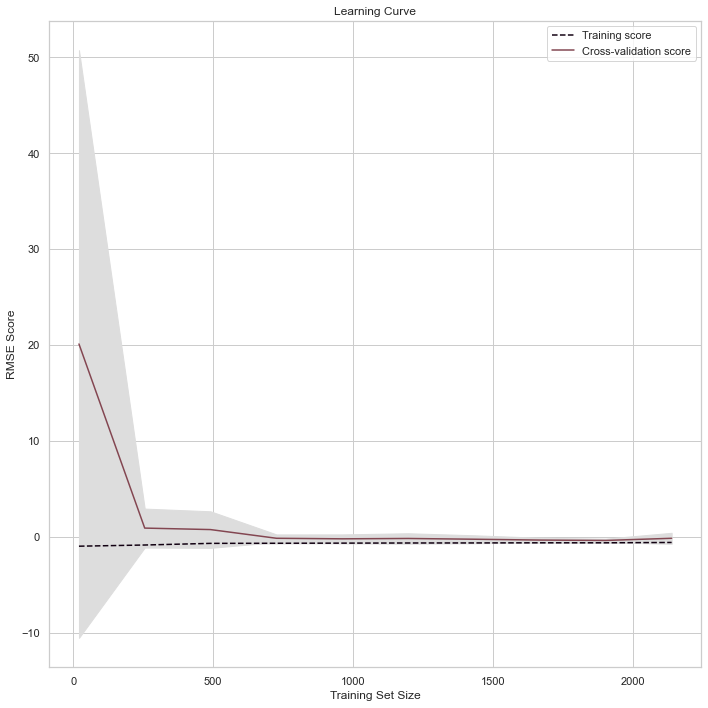

In [78]:
# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

Coeff R2 = 0.4253133176110738


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

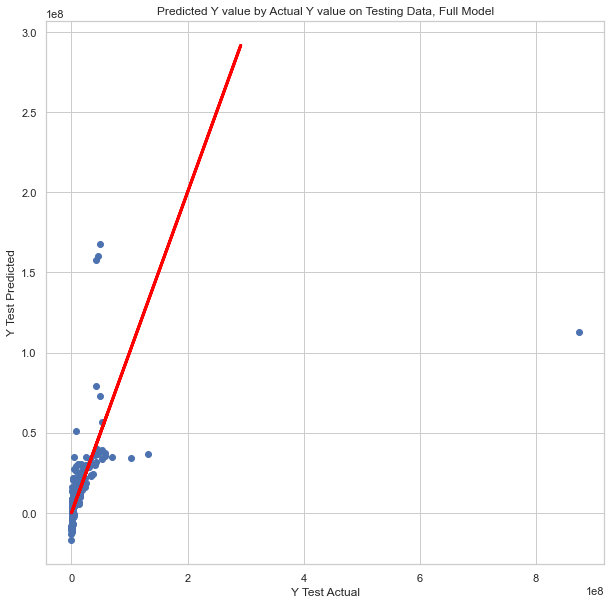

In [79]:
print('Coeff R2 =', las.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, las.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

In [80]:
folds = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':range(0, 1001, 50)}

model = Lasso()

model_cv = GridSearchCV(estimator = model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True
                       )

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Lasso(), param_grid={'alpha': range(0, 1001, 50)},
             return_train_score=True, scoring='r2', verbose=1)

In [81]:
cv_result_l = pd.DataFrame(model_cv.cv_results_)
cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
cv_result_l.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.075297,0.011162,0.002993,0.000773,0.0,{'alpha': 0},-0.00173,0.651229,0.342554,0.373788,0.372268,0.588901,0.623858,0.433695,0.788645,0.719144,0.489235,0.221237,21,0.674604,0.648781,0.697049,0.661116,0.689893,0.658017,0.656817,0.661995,0.630893,0.611859,0.659102,0.024045
1,0.073601,0.007619,0.002993,0.001180,50.0,{'alpha': 50},-0.00168,0.651252,0.342553,0.373835,0.372318,0.588930,0.623914,0.433747,0.788628,0.719119,0.489262,0.221221,20,0.674604,0.648781,0.697049,0.661116,0.689888,0.658016,0.656816,0.661995,0.630894,0.611861,0.659102,0.024043
2,0.071104,0.005825,0.002693,0.000638,100.0,{'alpha': 100},-0.00163,0.651275,0.342551,0.373882,0.372368,0.588959,0.623969,0.433798,0.788611,0.719094,0.489288,0.221205,19,0.674605,0.648780,0.697048,0.661115,0.689883,0.658014,0.656816,0.661994,0.630895,0.611862,0.659101,0.024042
3,0.073004,0.008112,0.002889,0.000823,150.0,{'alpha': 150},-0.00158,0.651298,0.342550,0.373929,0.372417,0.588987,0.624024,0.433847,0.788594,0.719069,0.489314,0.221190,18,0.674605,0.648780,0.697048,0.661115,0.689878,0.658013,0.656815,0.661993,0.630896,0.611864,0.659101,0.024041
4,0.073499,0.008066,0.003092,0.001037,200.0,{'alpha': 200},-0.00153,0.651321,0.342548,0.373976,0.372467,0.589014,0.624079,0.433896,0.788578,0.719044,0.489339,0.221174,17,0.674605,0.648779,0.697047,0.661114,0.689873,0.658012,0.656815,0.661992,0.630897,0.611865,0.659100,0.024040


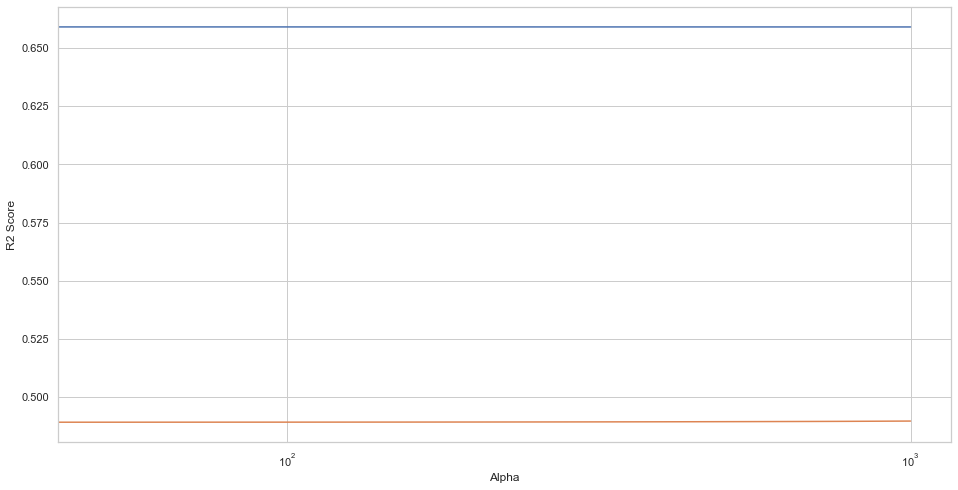

In [82]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_train_score'])
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_test_score'])
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.show()

In [83]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

{'alpha': 1000}

In [84]:
las = Lasso(alpha=0)
las.fit(X_train,y_train)

y_train_pred = las.predict(X_train)
y_test_pred = las.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.6560941781106276
0.20600220735604602


Coeff R2 = 0.4253133173419936


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

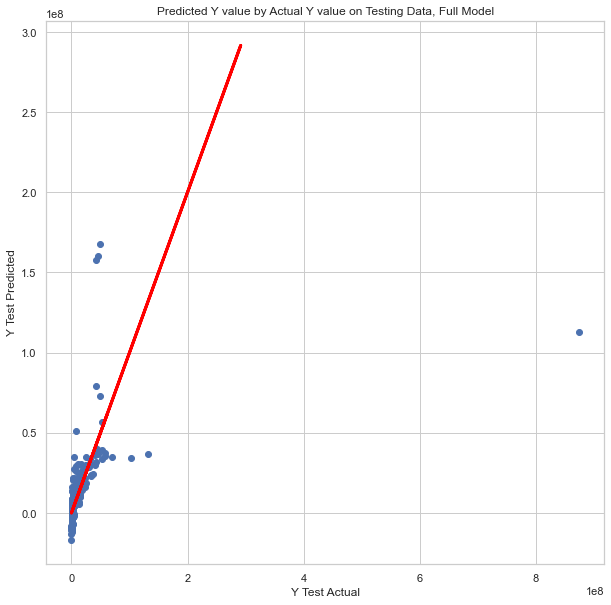

In [85]:
print('Coeff R2 =', las.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, las.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

### Cross-Validation 

In [86]:
results=cross_val_score(las,X,y,cv=kfold_validation)
print(results)
print(np.mean(results))

[ 0.37652433  0.53479248 -1.45050216  0.02944442  0.31287678  0.52043261
  0.64398167  0.12848411 -3.95213911  0.2218892 ]
-0.2634215669020292


## Ridge

In [87]:
rid = Ridge(alpha=0.001)
rid.fit(X_train,y_train)

y_train_pred = rid.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = rid.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.6561101168594234
0.19988997715584955


In [88]:
train_sizes, train_scores, test_scores = learning_curve(Ridge(), X, y, train_sizes=train_sizes, cv=5, scoring='r2')

In [89]:
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)

In [90]:
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

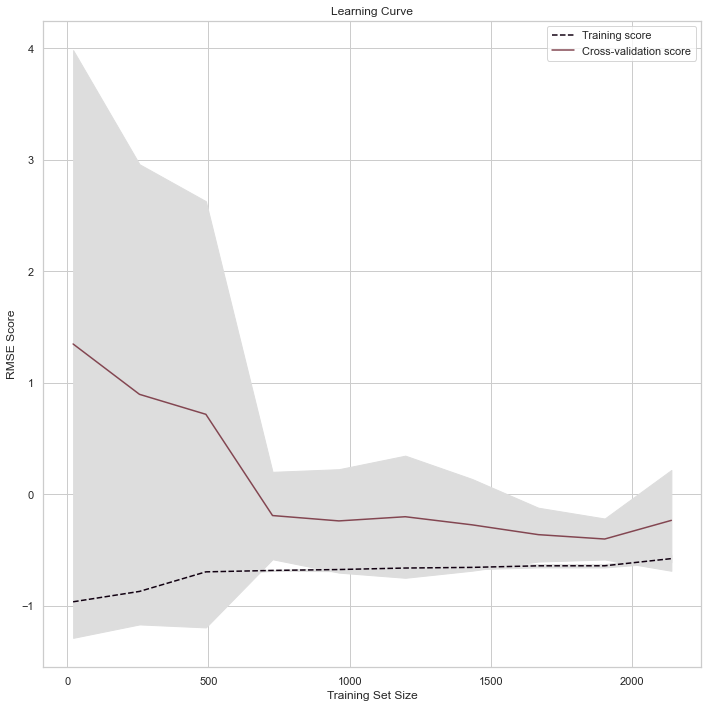

In [91]:
# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

In [92]:
rid = Ridge(alpha=0.001)
rid.fit(X_train,y_train)

y_train_pred = rid.predict(X_train)
print(r2_score(y_train,y_train_pred))
y_test_pred = rid.predict(X_test)
print(r2_score(y_test,y_test_pred))

0.6561101168594234
0.19988997715584955


Coeff R2 = 0.42218656387902587


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

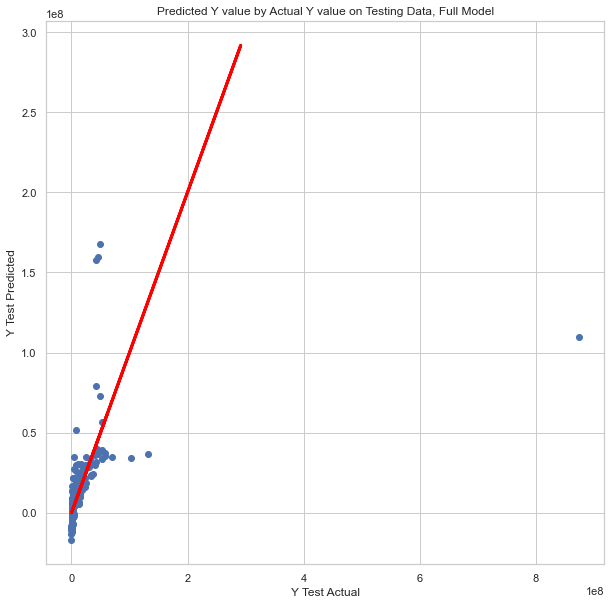

In [93]:
print('Coeff R2 =', rid.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, rid.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

In [94]:
folds  = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':range(0, 1001, 50)}

model = Ridge()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Ridge(), param_grid={'alpha': range(0, 1001, 50)},
             return_train_score=True, scoring='r2', verbose=1)

In [95]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r['param_alpha'] = cv_result_r['param_alpha'].astype('float32')
cv_result_r.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.004587,0.001352,0.002592,0.000914,0.0,{'alpha': 0},-0.005373,0.650580,0.342238,0.368909,0.360009,0.581809,0.621372,0.429460,0.780900,0.716475,0.484638,0.221259,19,0.674627,0.648863,0.697101,0.661176,0.690450,0.658193,0.656919,0.662073,0.631257,0.612070,0.659273,0.024038
1,0.006283,0.001342,0.003689,0.001096,50.0,{'alpha': 50},0.354198,0.645026,0.383123,0.429784,0.430275,0.601138,0.655611,0.495255,0.722254,0.601001,0.531766,0.122358,2,0.650565,0.625519,0.672142,0.641176,0.663821,0.637651,0.635702,0.641624,0.608718,0.592944,0.636986,0.022476
2,0.004289,0.000457,0.002392,0.000662,100.0,{'alpha': 100},0.480039,0.619317,0.389417,0.444374,0.435644,0.599835,0.662457,0.517880,0.666779,0.532071,0.534781,0.093555,1,0.618715,0.595416,0.639045,0.613642,0.630249,0.609543,0.606982,0.613583,0.580793,0.570730,0.607870,0.019818
3,0.004688,0.001184,0.002792,0.000869,150.0,{'alpha': 150},0.538102,0.595066,0.387326,0.451154,0.430097,0.596661,0.665478,0.530246,0.625535,0.487653,0.530732,0.086351,3,0.591617,0.570192,0.610936,0.589476,0.602180,0.584880,0.581778,0.588951,0.557707,0.552829,0.583055,0.017375
4,0.004587,0.001017,0.002492,0.000670,200.0,{'alpha': 200},0.569095,0.574445,0.382894,0.456144,0.422039,0.593605,0.667203,0.538444,0.594209,0.456561,0.525464,0.086317,4,0.569567,0.549874,0.588127,0.569397,0.579643,0.564401,0.560819,0.568470,0.539223,0.538582,0.562810,0.015371


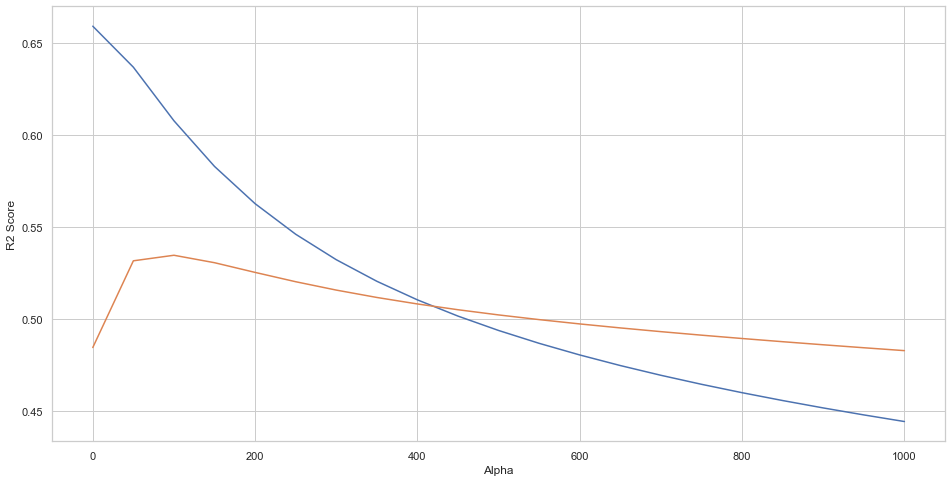

In [96]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_train_score'])
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_test_score'])
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.show()

In [97]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

{'alpha': 100}

In [98]:
rid = Ridge(alpha = 100)
rid.fit(X_train,y_train)

y_pred_train = rid.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = rid.predict(X_test)
print(r2_score(y_test,y_pred_test))

0.6105731755767362
0.2039864870440642


In [99]:
model_parameter = list(rid.coef_)
model_parameter.insert(0,rid.intercept_)
cols = df_pred_energy.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
ridge_coef.columns = ['Feature','Coef']

In [100]:
ridge_coef.sort_values(by='Coef',ascending=False).head(10)

,Feature,Coef
36,Library,1.807908e+07
48,Other - Restaurant/Bar,8.218250e+06
4,log_SiteEUI(kBtu/sf),6.705743e+06
1,log_NumberofFloors,5.012890e+06
3,log_PropertyGFABuilding(s),4.470510e+06
5,log_SourceEUI(kBtu/sf),4.052290e+06
2,log_PropertyGFATotal,3.523421e+06
6,log_Build_Age,1.282060e+06
40,Other - Education,1.143922e+06
7,log_surface_nb_building,7.564435e+05


Coeff R2 = 0.4021080870287467


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

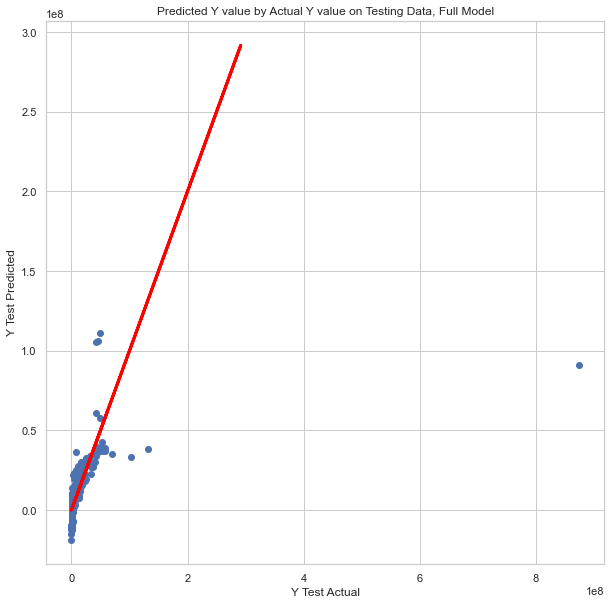

In [101]:
print('Coeff R2 =', rid.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, rid.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

### Cross-Validation 

In [102]:
results=cross_val_score(rid,X,y,cv=kfold_validation)
print(results)
print(np.mean(results))

[ 0.5098838   0.46528915  0.33778247 -0.04155826  0.47946281  0.60390173
  0.54151066  0.2584196  -1.11272501  0.19627596]
0.2238242911378551


## ElasticNet

In [103]:
elastic = ElasticNet(alpha=0.001)
elastic.fit(X_train,y_train)

y_train_pred = elastic.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = elastic.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.6560474476796865
0.21047863070153405


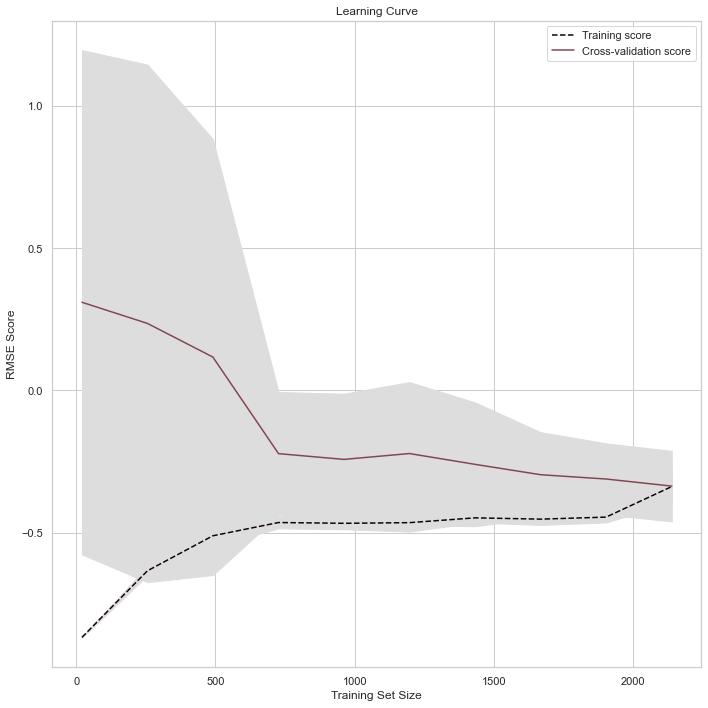

In [104]:
# Définir les tailles d'échantillon pour la courbe d'apprentissage
train_sizes = np.linspace(0.01, 1, 10)

# Calculer les scores pour chaque taille d'échantillon
train_sizes, train_scores, test_scores = learning_curve(ElasticNet(), X, y, train_sizes=train_sizes, cv=5, scoring='r2')

# Calculer les moyennes et les écarts-types des scores
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

In [105]:
folds  = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':range(0, 1001, 50)}

model = ElasticNet()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ElasticNet(), param_grid={'alpha': range(0, 1001, 50)},
             return_train_score=True, scoring='r2', verbose=1)

In [106]:
cv_result_e = pd.DataFrame(model_cv.cv_results_)
cv_result_e['param_alpha'] = cv_result_e['param_alpha'].astype('float32')
cv_result_e.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.078784,0.012654,0.002893,0.000827,0.0,{'alpha': 0},-0.001730,0.651229,0.342554,0.373788,0.372268,0.588901,0.623858,0.433695,0.788645,0.719144,0.489235,0.221237,1,0.674604,0.648781,0.697049,0.661116,0.689893,0.658017,0.656817,0.661995,0.630893,0.611859,0.659102,0.024045
1,0.005385,0.001558,0.002592,0.000914,50.0,{'alpha': 50},0.149772,0.069716,0.062893,0.156462,0.062473,0.133789,0.151193,0.143520,0.066052,0.043335,0.103920,0.043856,2,0.083049,0.081788,0.085554,0.083800,0.085716,0.081241,0.076908,0.082603,0.081634,0.088033,0.083033,0.002891
2,0.005385,0.001425,0.002792,0.000747,100.0,{'alpha': 100},0.076149,0.036143,0.034678,0.067655,0.034431,0.071234,0.081080,0.062966,0.033595,0.021666,0.051960,0.020696,3,0.045825,0.045095,0.047117,0.046201,0.047247,0.044790,0.042240,0.045500,0.044991,0.048617,0.045762,0.001639
3,0.004488,0.001022,0.002891,0.000829,150.0,{'alpha': 150},0.047541,0.023508,0.023918,0.032517,0.023764,0.047231,0.054293,0.031406,0.021392,0.013596,0.031917,0.012758,4,0.031646,0.031133,0.032513,0.031895,0.032614,0.030923,0.029120,0.031400,0.031056,0.033585,0.031588,0.001142
4,0.005290,0.001487,0.002888,0.000825,200.0,{'alpha': 200},0.032337,0.016876,0.018242,0.013712,0.018141,0.034540,0.040155,0.014581,0.014991,0.009378,0.021295,0.009880,5,0.024168,0.023773,0.024821,0.024354,0.024902,0.023613,0.022220,0.023972,0.023713,0.025654,0.024119,0.000877


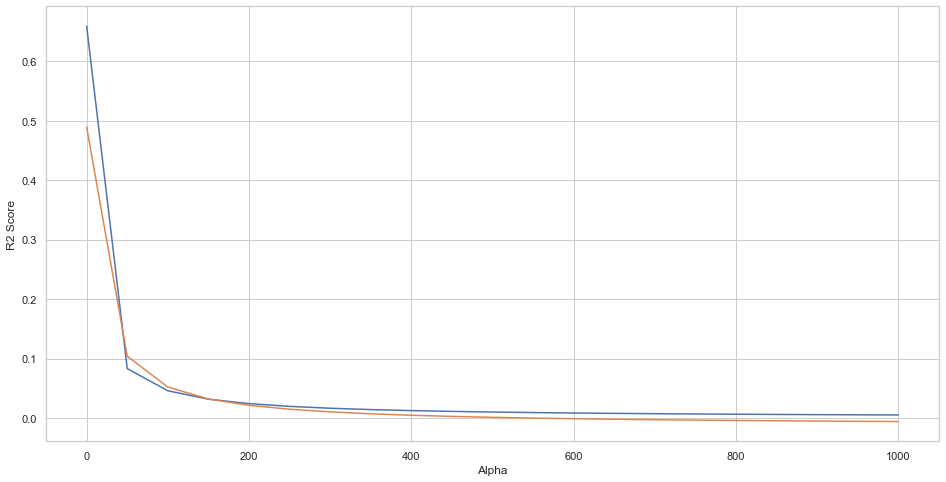

In [107]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_e['param_alpha'],cv_result_e['mean_train_score'])
plt.plot(cv_result_e['param_alpha'],cv_result_e['mean_test_score'])
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.show()

In [108]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

{'alpha': 0}

In [109]:
elastic = ElasticNet(alpha = 0)
elastic.fit(X_train,y_train)

y_pred_train = elastic.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = elastic.predict(X_test)
print(r2_score(y_test,y_pred_test))

0.6560941781106276
0.20600220735604602


Coeff R2 = 0.4253133173419936


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

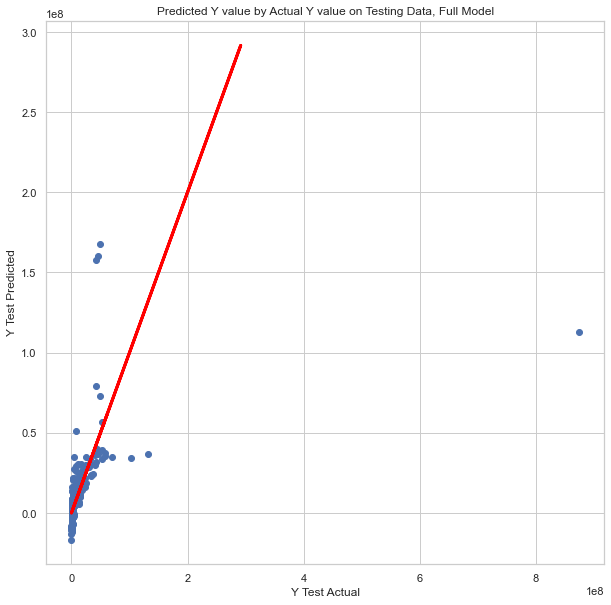

In [110]:
print('Coeff R2 =', elastic.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, elastic.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

## GradientBoostingRegressor

In [111]:
GB = GradientBoostingRegressor()
GB.fit(X_train,y_train)

y_train_pred = GB.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = GB.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.9956361477548946
0.270652613535311


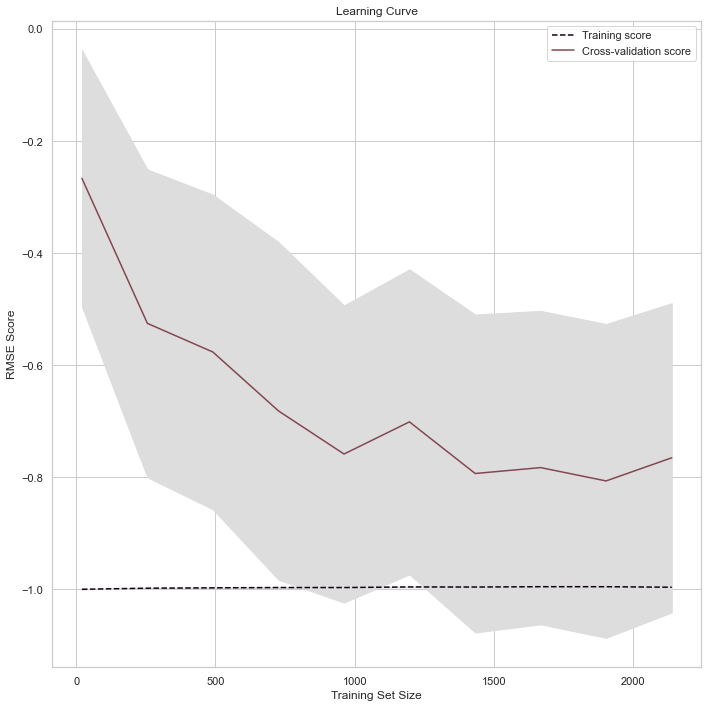

In [112]:
# Définir les tailles d'échantillon pour la courbe d'apprentissage
train_sizes = np.linspace(0.01, 1, 10)

# Calculer les scores pour chaque taille d'échantillon
train_sizes, train_scores, test_scores = learning_curve(GradientBoostingRegressor(), X, y, train_sizes=train_sizes, cv=5, scoring='r2')

# Calculer les moyennes et les écarts-types des scores
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

In [113]:
#folds  = KFold(n_splits=10,shuffle=True,random_state=42)

#hyper_param = {'n_estimators':range(80), 
#                  'max_depth':[14],
#                  'min_samples_split':[100],
#                  'max_features':[10],
#                  'subsample':[1]}


#model = GradientBoostingRegressor()

#model_cv = GridSearchCV(estimator=model,
#                        param_grid=hyper_param,
#                        scoring='r2',
#                        cv=folds,
#                        verbose=1,
#                        return_train_score=True)

#model_cv.fit(X_train,y_train)

In [114]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.078784,0.012654,0.002893,0.000827,0,{'alpha': 0},-0.001730,0.651229,0.342554,0.373788,0.372268,0.588901,0.623858,0.433695,0.788645,0.719144,0.489235,0.221237,1,0.674604,0.648781,0.697049,0.661116,0.689893,0.658017,0.656817,0.661995,0.630893,0.611859,0.659102,0.024045
1,0.005385,0.001558,0.002592,0.000914,50,{'alpha': 50},0.149772,0.069716,0.062893,0.156462,0.062473,0.133789,0.151193,0.143520,0.066052,0.043335,0.103920,0.043856,2,0.083049,0.081788,0.085554,0.083800,0.085716,0.081241,0.076908,0.082603,0.081634,0.088033,0.083033,0.002891
2,0.005385,0.001425,0.002792,0.000747,100,{'alpha': 100},0.076149,0.036143,0.034678,0.067655,0.034431,0.071234,0.081080,0.062966,0.033595,0.021666,0.051960,0.020696,3,0.045825,0.045095,0.047117,0.046201,0.047247,0.044790,0.042240,0.045500,0.044991,0.048617,0.045762,0.001639
3,0.004488,0.001022,0.002891,0.000829,150,{'alpha': 150},0.047541,0.023508,0.023918,0.032517,0.023764,0.047231,0.054293,0.031406,0.021392,0.013596,0.031917,0.012758,4,0.031646,0.031133,0.032513,0.031895,0.032614,0.030923,0.029120,0.031400,0.031056,0.033585,0.031588,0.001142
4,0.005290,0.001487,0.002888,0.000825,200,{'alpha': 200},0.032337,0.016876,0.018242,0.013712,0.018141,0.034540,0.040155,0.014581,0.014991,0.009378,0.021295,0.009880,5,0.024168,0.023773,0.024821,0.024354,0.024902,0.023613,0.022220,0.023972,0.023713,0.025654,0.024119,0.000877
5,0.005186,0.001321,0.002792,0.000747,250,{'alpha': 250},0.022906,0.012791,0.014734,0.002004,0.014669,0.026690,0.031419,0.004127,0.011049,0.006785,0.014717,0.009183,6,0.019549,0.019228,0.020072,0.019697,0.020140,0.019099,0.017963,0.019386,0.019178,0.020753,0.019507,0.000711
6,0.004385,0.000491,0.002592,0.000661,300,{'alpha': 300},0.016485,0.010021,0.012352,-0.005987,0.012311,0.021354,0.025485,-0.002998,0.008376,0.005030,0.010243,0.009343,7,0.016413,0.016142,0.016848,0.016535,0.016907,0.016034,0.015075,0.016273,0.016099,0.017424,0.016375,0.000598
7,0.005387,0.001282,0.002991,0.000894,350,{'alpha': 350},0.011830,0.008019,0.010628,-0.011788,0.010606,0.017492,0.021191,-0.008165,0.006445,0.003763,0.007002,0.009776,8,0.014143,0.013909,0.014517,0.014248,0.014568,0.013816,0.012988,0.014021,0.013872,0.015016,0.014110,0.000516
8,0.005679,0.001010,0.002894,0.000833,400,{'alpha': 400},0.008302,0.006505,0.009323,-0.016190,0.009315,0.014567,0.017940,-0.012084,0.004985,0.002805,0.004547,0.010262,9,0.012425,0.012219,0.012752,0.012517,0.012798,0.012138,0.011408,0.012317,0.012187,0.013192,0.012395,0.000454
9,0.004792,0.001327,0.003091,0.000828,450,{'alpha': 450},0.005536,0.005320,0.008300,-0.019645,0.008304,0.012275,0.015394,-0.015159,0.003841,0.002056,0.002622,0.010726,10,0.011080,0.010895,0.011370,0.011161,0.011411,0.010823,0.010170,0.010982,0.010866,0.011764,0.011052,0.000405


In [115]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

{'alpha': 0}

In [116]:
folds  = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'n_estimators':[80], 
                  'max_depth':[14],
                  'min_samples_split':[100],
                  'max_features':[10],
                  'subsample':[1]}


model = GradientBoostingRegressor()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [14], 'max_features': [10],
                         'min_samples_split': [100], 'n_estimators': [80],
                         'subsample': [1]},
             return_train_score=True, scoring='r2', verbose=1)

In [117]:
y_train_pred = model_cv.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = model_cv.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.9976448473049306
0.34294650411833527


Coeff R2 = 0.6238455127626467


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

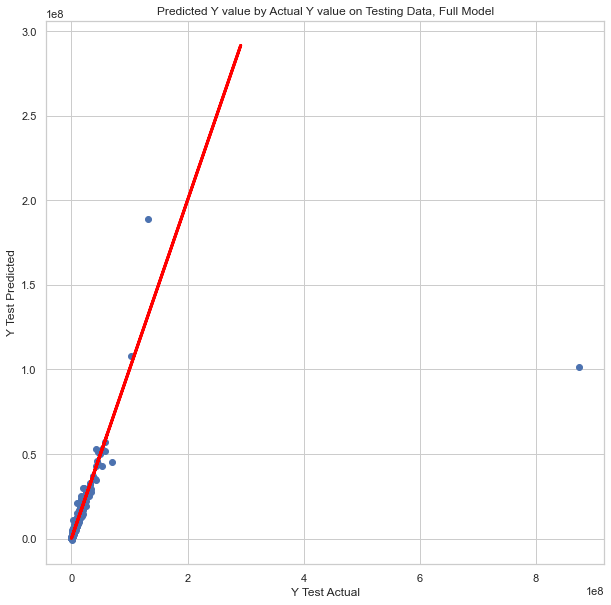

In [118]:
print('Coeff R2 =', GB.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, GB.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

## RandomForestRegressor
Les hyperparamètres courants pour un RandomForestRegressor sont les suivants:

* n_estimators: nombre d'arbres de décision dans la forêt.
* criterion: fonction de coût utilisée pour mesurer la qualité de chaque séparation.
* max_depth: profondeur maximale de chaque arbre.
* min_samples_split: nombre minimum d'échantillons nécessaires pour diviser un noeud.
* min_samples_leaf: nombre minimum d'échantillons requis pour être un noeud feuille.
* min_weight_fraction_leaf: fraction minimale du poids total d'échantillons requis pour être un noeud feuille.
* max_features: nombre maximum de caractéristiques considérées lors de la recherche d'une meilleure séparation.
* max_leaf_nodes: nombre maximal de noeuds feuilles dans chaque arbre.
* min_impurity_decrease: réduit minimale de l'impureté pour diviser un noeud.



In [119]:
# With no clear pattern detected, let's fit a random forest and check for feature importances.
rfr = RandomForestRegressor(n_estimators = 80, criterion = 'mse', random_state= 8, oob_score  = True)
rfr.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', n_estimators=80, oob_score=True,
                      random_state=8)

In [120]:
print(rfr.oob_score_)
# This is the R_squared on out-of-bag training data.

0.8993275967436788


In [121]:
#np.mean((rfr.predict(X_test) - y_test)**2)
# This is the RSE on testing data.
# Given the magnitude of the response variable y, this is actually pretty impressive!

Coeff R2 = 0.598730579549132


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

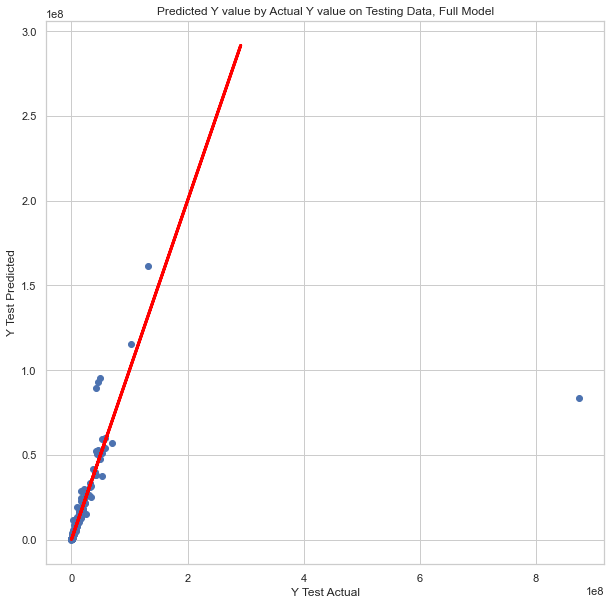

In [122]:
print('Coeff R2 =', rfr.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, rfr.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

## XGBRegressor

In [123]:
from xgboost import XGBRegressor

In [124]:
XGB = XGBRegressor()

In [125]:
XGB = XGBRegressor(n_estimators=1000, learning_rate=0.1)
XGB.fit(X_train, y_train, early_stopping_rounds=26, 
             eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Coeff R2 = 0.6345585719705797


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

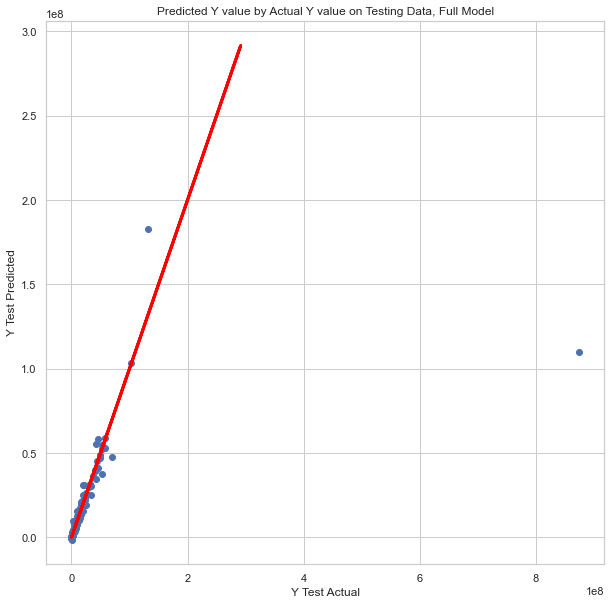

In [126]:
print('Coeff R2 =', XGB.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, XGB.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

# Model vs ENERGYSTARScore 